In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
dataset_path = 'dataset.csv'  # Ensure this is the correct path
df = pd.read_csv(dataset_path, encoding='iso-8859-1', sep=',')


In [3]:
print("Dataset Head:")
print(df.head())

Dataset Head:
                            name  fuel  capacity  \
0                       Shotwick     1   72.2090   
1                    MOD Lyneham     1   69.8000   
2         Owl's Hatch Solar Park     1   51.9376   
3  Wroughton Airfield Solar Park     1   50.0000   
4                   West Raynham     1   49.9000   

                                 owner      cost  average_generation  \
0                 Foresight Solar Fund  79.42990        109437.86160   
1  Defence Infrastructure Organisation  76.78000        105786.85120   
2       Cubico Sustainable Investments  62.32512         78715.11696   
3                     Rockfire Capital  60.00000         75778.54671   
4                      Bluefield Solar  59.88000         75626.98962   

   annual_revenue  annual_operating_expense  annual_profit  payback_period  \
0       21.887766                  2.735947      19.151819        4.147381   
1       21.157564                  2.644671      18.512892        4.147380   
2     

In [4]:
print("Dataset Tail:")
print(df.tail())

Dataset Tail:
                              name  fuel  capacity  \
1945  Goonabarn Farm Wind Turbines     0       1.0   
1946                   Magherafelt     0       1.0   
1947                Yonderton Farm     0       1.0   
1948                   New Holland     0       1.0   
1949         East Midlands Airport     0       1.0   

                                  owner  cost  average_generation  \
1945  George Richards Farms Partnership  2.55         3020.689655   
1946        Tobermore Concrete Products  2.55         3020.689655   
1947               Green Cat Renewables  2.55         3020.689655   
1948                        Windflow UK  2.55         3020.689655   
1949                        Wind Direct  2.55         3020.689655   

      annual_revenue  annual_operating_expense  annual_profit  payback_period  \
1945        0.604331                  0.075517       0.528814         4.82211   
1946        0.604331                  0.075517       0.528814         4.82211   
194

In [3]:
# Add 'irradiance_wind' feature if needed
df['irradiance_wind'] = df['average_generation']


In [4]:
# Calculate 'irr' based on the given NPV and initial cost
df['calculated_cost'] = df['capacity']
df['irr'] = (((df['npv'] / df['calculated_cost']) - 1)/ 25) * 100


In [5]:
# Define features and target variable
reference_features = [
    'fuel', 'capacity', 'calculated_cost', 'irradiance_wind', 'annual_revenue',
    'annual_operating_expense', 'annual_profit', 'payback_period', 'npv', 'roi', 'irr'
]

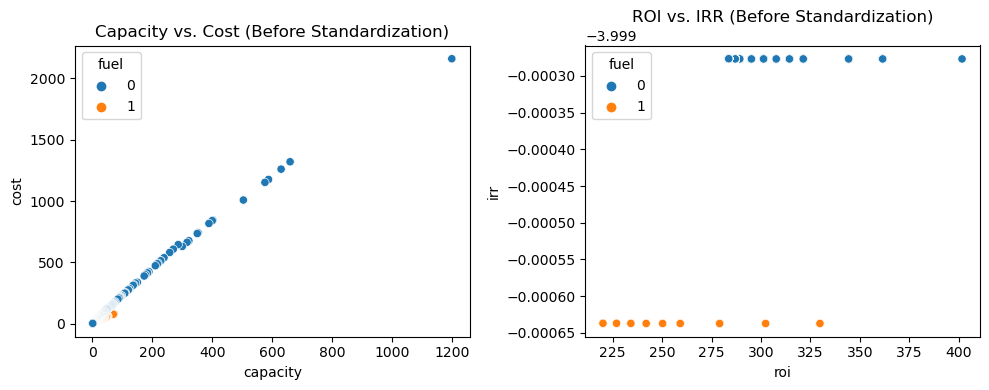

In [8]:
# Select some features to visualize
features_to_plot = ['capacity', 'calculated_cost', 'roi', 'irr', 'payback_period']

# Plot data 
plt.figure(figsize=(10, 4))

# Scatter plot of capacity vs. calculated_cost
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='capacity', y='cost', hue='fuel')
plt.title("Capacity vs. Cost (Before Standardization)")
# Scatter plot of ROI vs. IRR
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='roi', y='irr', hue='fuel')
plt.title("ROI vs. IRR (Before Standardization)")

plt.tight_layout()
plt.show()

In [6]:
def should_invest(capacity, cost, roi, irr, payback_period):
    # Cost-Capacity Relation
    # Allow for investment if cost is within a certain range of capacity
    if cost == capacity:
        return True  # Cost is within a reasonable multiple of capacity
    
    # Other indicators
    if roi < 285:
        return False  # ROI below 100% is a bad sign
    if roi >= 285:
        return True  # ROI greater than or equal to 150% is a good sign
    if irr > 6:
        return True  # IRR over 6% is a positive indicator
    if payback_period < 5:
        return True  # Payback period less than 5 years is a good sign
    
    return False  # Default to not invest


In [7]:

# Apply the function to create 'investment_recommended'
df['investment_recommended'] = df.apply(
    lambda row: should_invest(
        row['capacity'], row['calculated_cost'], row['roi'], row['irr'], row['payback_period']
    ),
    axis=1
).astype(int)


In [8]:
# Split the data into training and test sets
X = df[reference_features]
y = df['investment_recommended']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

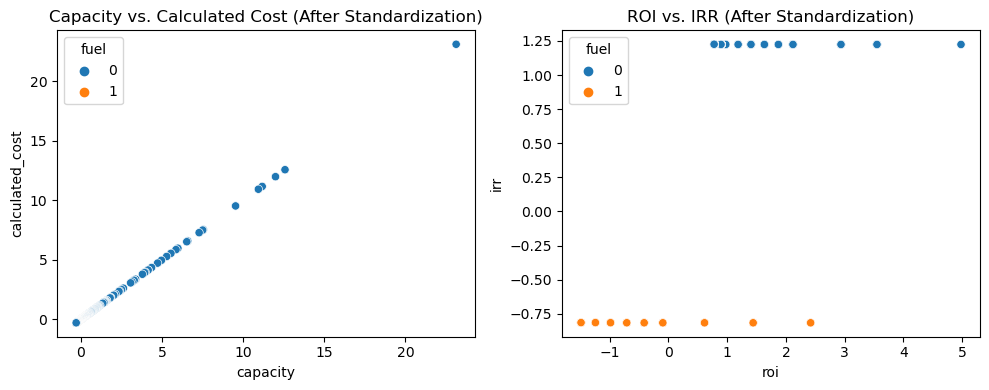

In [14]:
# Standardize the features
scaler = StandardScaler()
df_standardized = df.copy()  # Create a copy of the dataset
df_standardized[features_to_plot] = scaler.fit_transform(df[features_to_plot])

# Plot data after standardization
plt.figure(figsize=(10, 4))

# Scatter plot of capacity vs. calculated_cost (standardized)
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_standardized, x='capacity', y='calculated_cost', hue='fuel')
plt.title("Capacity vs. Calculated Cost (After Standardization)")

# Scatter plot of ROI vs. IRR (standardized)
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_standardized, x='roi', y='irr', hue='fuel')
plt.title("ROI vs. IRR (After Standardization)")

plt.tight_layout()
plt.show()

In [10]:
# Train an SVM classifier with a linear kernel
svm = SVC(kernel='linear', random_state=42, probability=True)  # Set probability=True for ROC curve
svm.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [11]:
# Predict on the test set
y_pred = svm.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print("Model Performance Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Model Performance Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


In [12]:
# Function to make predictions on the dataset and display a sample of results
def predict_on_dataset(model, scaler, X):
    # Scale the features using the fitted scaler
    X_scaled = scaler.transform(X)
    # Predict using the trained model
    predictions = model.predict(X_scaled)
    # Add predictions to the original DataFrame for comparison
    df['predicted_investment'] = predictions
    # Display a sample of the predictions alongside the actual values
    sample_predictions = df[['investment_recommended', 'predicted_investment']].head(10)
    print("\nSample Predictions:\n", sample_predictions)

# Call the prediction function to test on the same dataset
predict_on_dataset(svm, scaler, X)



Sample Predictions:
    investment_recommended  predicted_investment
0                       1                     1
1                       1                     1
2                       1                     1
3                       1                     1
4                       1                     1
5                       1                     1
6                       1                     1
7                       1                     1
8                       1                     1
9                       1                     1


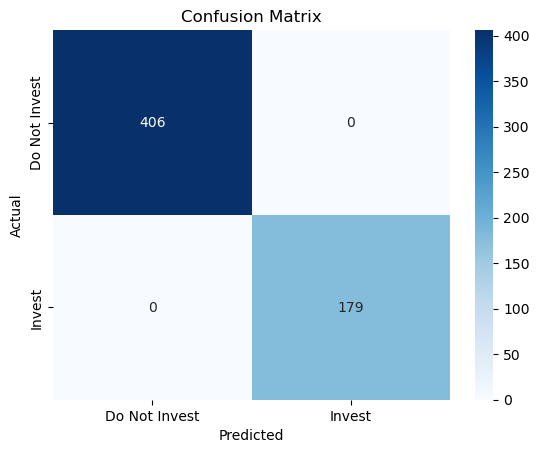

In [17]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Do Not Invest', 'Invest'], yticklabels=['Do Not Invest', 'Invest'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


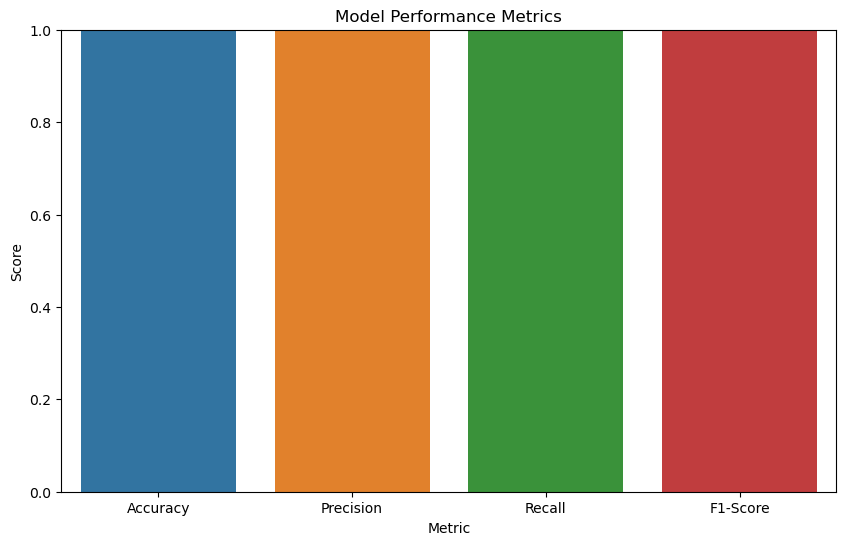

In [18]:
# Plot the model performance metrics
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
}

metrics_df = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=metrics_df)
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.show()


In [14]:
# Save the trained model and scaler
joblib.dump(svm, 'svm_investment_new.joblib')  # Save the trained SVM model


['svm_investment_new.joblib']

In [15]:
joblib.dump(scaler, 'svm_scalerr_new.joblib')  # Save the scaler

['svm_scalerr_new.joblib']